# Estimating Gentrification using Street View Images and Embeddings

This script (initially produced by ChatGPT) does the following (_this was my query_):
 - Read a spatial boundary file (that I will hard code)
 - Obtain the road network (from OSM?) for that area
 - Generate sample points on the road network roughly X meters apart
 - At each sample point, download the most recent street images for that location (either a single 360 degree view of a few smaller images). Use whichever API service is the most appropriate for obtaining the images. Importantly please record the date that the image was taken.
 - For each image, calculate an embedding using an appropriate foundation model (one that has been pre-trained to distinguish street environments specifically). Please use Hugging Face libraries.
 - If necessary, calculate the mean embedding for each point (is this the best way to calculate a single embedding for a point represented by multiple images?)
 - Now, for each sampled point there will be a dataframe with information about the point and its embedding. Read another polygon spatial data file, that I will provide, which contains area-level estimates of gentrification.
 - Use point-in-polygon to get the gentrification for each point.
 - Use cross-validation to train a couple of ML models (probaly random forest, linear regression and a neural network) to estimate gentrification from the embedding vectors
 - Choose the best model and parameter configuration and test this model on some held-out data.

## Configuration and library loading

In [31]:
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from pathlib import Path
import pickle
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import numpy as np
# import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing
import json

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# File paths
data_dir = Path(os.path.join("..", "data", "airbnb-manchester"))
lsoas_file = os.path.join("..", "data/SpatialData/", "LSOAs_2011", "LSOA_2011_EW_BSC_V4.shp")
points_data_cache = data_dir / "points_with_embeddings.pkl"
imd_file = os.path.join("..", "data", "imd", "File_2_-_IoD2019_Domains_of_Deprivation.xlsx")

### Get the LSOA spatial data

In [2]:
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]
gm_lsoa = gm_lsoa.to_crs(epsg=4326)

## Load the Embeddings

In [3]:
with open(points_data_cache, "rb") as f:
    point_records = pickle.load(f)

### Join image embeddings points to gentrification LSOAs

In [4]:
point_coords = [Point(rec['longitude'], rec['latitude']) for rec in point_records]
points_labels_gdf = gpd.GeoDataFrame(point_records, geometry=point_coords, crs="EPSG:4326")

# Perform spatial join to get gentrification label for each point
points_labels_gdf = gpd.sjoin(points_labels_gdf, gm_lsoa, how='inner', predicate='within')
# sjoin may add an index from the polygon ('index_right'); we can drop it
if 'index_right' in points_labels_gdf.columns:
    points_labels_gdf = points_labels_gdf.drop(columns=['index_right'])

print(f"Points after spatial join: {len(points_labels_gdf)} / {len(point_records)}"
      f" `(some points may lie outside the label polygons and were dropped)")

Points after spatial join: 18897 / 18897 `(some points may lie outside the label polygons and were dropped)


# Aggregating the image imbeddings

### Remove any embeddings which currently include more than one embedding

In [5]:
points_labels_gdf['embedding_shape'] = points_labels_gdf['embedding'].apply(lambda x: np.array(x).shape)

# Keep only rows NOT equal to (4, 768)
points_labels_gdf = points_labels_gdf[points_labels_gdf['embedding_shape'] != (4, 768)].copy()

# # Optional: check remaining shapes
# print(points_labels_gdf['embedding_shape'].value_counts())

### Find a measure of the embedding diversity - based on cosine similarity

In [6]:
# Ensure embeddings are numpy arrays
points_labels_gdf['embedding'] = points_labels_gdf['embedding'].apply(np.array)

# Define diversity function
def embedding_diversity(embeddings_list):
    if len(embeddings_list) < 2:
        return 0.0  # trivial: only one point
    X = np.stack(embeddings_list)
    sim_matrix = cosine_similarity(X)
    n = len(X)
    mean_sim = (sim_matrix.sum() - n) / (n*(n-1))
    diversity = 1 - mean_sim  # higher = more diverse
    return diversity

# Group by LSOA and compute diversity
lsoa_diversity = points_labels_gdf.groupby('LSOA11CD')['embedding'].apply(
    lambda x: embedding_diversity(list(x))).reset_index(name='diversity')

### Plot LSOA-level embedding diversity

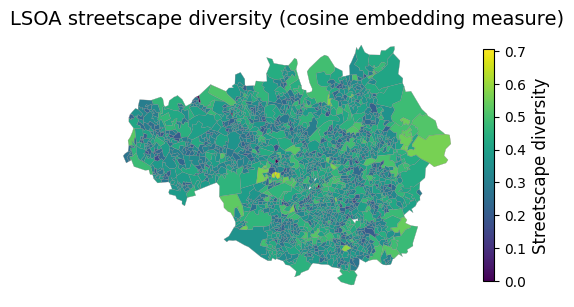

In [7]:
# Merge geometry into the diversity table
lsoa_diversity_gdf = lsoa_diversity.merge( gm_lsoa[['LSOA11CD', 'geometry']], on='LSOA11CD', how='left')
# Convert to a GeoDataFrame
lsoa_diversity_gdf = gpd.GeoDataFrame(lsoa_diversity_gdf, geometry='geometry')

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot the LSOAs without the built-in legend
gdf_plot = lsoa_diversity_gdf.plot(column='diversity', cmap='viridis', linewidth=0.2, edgecolor='grey', legend=False, ax=ax)

# Create a ScalarMappable for the colorbar
sm = mpl.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=lsoa_diversity_gdf['diversity'].min(), 
                                                                     vmax=lsoa_diversity_gdf['diversity'].max()))
sm._A = []  

# Add colorbar matching the plot
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)  # fraction controls height, pad controls distance
cbar.set_label("Streetscape diversity", fontsize=12)

ax.set_title("LSOA streetscape diversity (cosine embedding measure)", fontsize=14)
ax.axis('off');

### Find the mean embedding per LSOA

In [8]:
def mean_embed(x):
    return np.mean(np.vstack(x), axis=0)

avg_embeddings = (
    points_labels_gdf.groupby("LSOA11CD")["embedding"]
      .apply(mean_embed)
      .reset_index())
avg_embeddings_gdf = avg_embeddings.merge( gm_lsoa[['LSOA11CD', 'geometry']], on='LSOA11CD', how='left')

### Find the diversity of embedding per LSOA

In [9]:
lsoa_diversity_gdf = lsoa_diversity.merge( gm_lsoa[['LSOA11CD', 'geometry']], on='LSOA11CD', how='left')
lsoa_diversity_gdf = gpd.GeoDataFrame(lsoa_diversity_gdf, geometry='geometry')

# Running ML model to predict deprivation score from embeddings

### Get IMD data

In [12]:
# Read Excel file
imd = pd.read_excel(imd_file, sheet_name="IoD2019 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {
    "LSOA code (2011)": "LSOA11CD",
    "LSOA name (2011)": "lsoa_2011_name",
    "Local Authority District code (2019)": "lad_2019_code",
    "Local Authority District name (2019)": "lad_2019_name",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile",
    "Income Rank (where 1 is most deprived)": "income_rank",
    "Income Decile (where 1 is most deprived 10% of LSOAs)": "income_decile",
    "Employment Rank (where 1 is most deprived)": "employment_rank",
    "Employment Decile (where 1 is most deprived 10% of LSOAs)": "employment_decile",
    "Education, Skills and Training Rank (where 1 is most deprived)": "education_rank",
    "Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)": "education_decile",
    "Health Deprivation and Disability Rank (where 1 is most deprived)": "health_rank",
    "Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)": "health_decile",
    "Crime Rank (where 1 is most deprived)": "crime_rank",
    "Crime Decile (where 1 is most deprived 10% of LSOAs)": "crime_decile",
    "Barriers to Housing and Services Rank (where 1 is most deprived)": "housing_rank",
    "Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)": "housing_decile",
    "Living Environment Rank (where 1 is most deprived)": "environment_rank",
    "Living Environment Decile (where 1 is most deprived 10% of LSOAs)": "environment_decile"}
imd = imd.rename(columns=imd_col_map)

### Join with embeddings, so we have for each LSOA an average embedding and an IMD ranking

In [13]:
avg_embeddings_with_imd_gdf = pd.merge(left=avg_embeddings_gdf, right=imd, on="LSOA11CD")
avg_embeddings_with_imd_gdf = gpd.GeoDataFrame(avg_embeddings_with_imd_gdf, geometry='geometry')
# avg_embeddings_with_imd_gdf.plot(column="imd_rank", legend=True)

### Build model

In [14]:
X = np.stack(avg_embeddings_with_imd_gdf["embedding"].values)     # shape (n_points, embed_dim)
y = avg_embeddings_with_imd_gdf['imd_rank'].values

print("Feature matrix shape:", X.shape, "Target vector shape:", y.shape)

Feature matrix shape: (1669, 768) Target vector shape: (1669,)


In [28]:
# Split data into training and test sets
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X , y, np.arange(X.shape[0]), test_size=0.2, random_state=42)
print(f"Training points: {X_train.shape[0]}, Test points: {X_test.shape[0]}")

# Define model pipelines and parameter grids for cross-validation
models = []
param_grids = []

# 1. Linear Regression (with standard scaling)
pipe_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())])
# No hyperparameters to tune for plain LinearRegression (we could consider Ridge/Lasso alphas, but skip for simplicity)
models.append(pipe_linear)
param_grids.append({})  # empty grid means just evaluate the baseline linear model

# 2. Random Forest Regressor
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),  # scaler doesn't affect RF but included for uniformity
    ('reg', RandomForestRegressor(random_state=42))])


models.append(pipe_rf)
param_grids.append({
    'reg__n_estimators': [100, 200],   # try 100 and 200 trees
    'reg__max_depth': [None, 10, 20] }) # try unlimited depth and a couple of depth limits

# 3. Neural Network (MLPRegressor)
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', MLPRegressor(max_iter=2000,  early_stopping=True, n_iter_no_change=20,random_state=42))])


models.append(pipe_mlp)
param_grids.append({
    'reg__hidden_layer_sizes': [(100,), (100,50)],  # one hidden layer vs two layers
    'reg__alpha': [1e-4, 1e-3]})  # L2 regularization strengths
    # (Other hyperparameters like learning_rate_init can be added if needed)

# Perform cross-validation for each model to find the best hyperparameters
best_model = None
best_score = -np.inf
best_model_name = None
best_params = {}

print("Training models")
cv = KFold(n_splits=5, shuffle=True, random_state=42)
ncores = min(multiprocessing.cpu_count()-1, 100)
print(f"USing {ncores} cores.")  # Take all cores but one, and not more than 100 (don't want to kill the HPC)
for model, param_grid, name in zip(models, param_grids, ["LinearReg", "RandomForest", "NeuralNet"]):
    print(f"\tTraining: {model}...")
    if param_grid:
        # Use GridSearchCV for models with hyperparameters
        grid = GridSearchCV(model, param_grid, cv=cv, scoring='r2', n_jobs=ncores)
        grid.fit(X_train, y_train)
        cv_score = grid.best_score_
        model_best = grid.best_estimator_
        params_best = grid.best_params_
    else:
        # For Linear Regression (no params to tune), just do cross_val_score
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
        cv_score = np.mean(scores)
        model.fit(X_train, y_train)  # train on full training data
        model_best = model
        params_best = {}
    print(f"{name} CV mean R^2 = {cv_score:.3f} {('(best params: '+str(params_best)+')') if params_best else ''}")
    # Track the best model
    if cv_score > best_score:
        best_score = cv_score
        best_model = model_best
        best_model_name = name
        best_params = params_best.copy()         # <- capture the *winning* params


print(f"Best model from CV: {best_model_name} with R^2 = {best_score:.3f} and params {best_params}")

# Save the meta-data so the model can be trained on the different domains of deprivation
best_model_info = {
    "model_name": best_model_name,
    "best_score": float(best_score),
    "best_params": best_params}
with open(os.path.join(data_dir, "5-imd_best_model_info.json"), "w") as f:
    json.dump(best_model_info, f, indent=2)
print(f"Cached model info:", best_model_info)

Training points: 1335, Test points: 334
Training models
USing 31 cores.
	Training: Pipeline(steps=[('scaler', StandardScaler()), ('reg', LinearRegression())])...
LinearReg CV mean R^2 = -0.151 
	Training: Pipeline(steps=[('scaler', StandardScaler()),
                ('reg', RandomForestRegressor(random_state=42))])...
RandomForest CV mean R^2 = 0.569 (best params: {'reg__max_depth': 10, 'reg__n_estimators': 200})
	Training: Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 MLPRegressor(early_stopping=True, max_iter=2000,
                              n_iter_no_change=20, random_state=42))])...
NeuralNet CV mean R^2 = 0.593 (best params: {'reg__alpha': 0.001, 'reg__hidden_layer_sizes': (100, 50)})
Best model from CV: NeuralNet with R^2 = 0.593 and params {'reg__alpha': 0.001, 'reg__hidden_layer_sizes': (100, 50)}


### Save the best model info

In [29]:
# Save the meta-data so the model can be trained on the different domains of deprivation
best_model_info = {
    "model_name": best_model_name,
    "best_score": float(best_score),
    "best_params": best_params}
with open(os.path.join(data_dir, "5-imd_best_model_info.json"), "w") as f:
    json.dump(best_model_info, f, indent=2)
print(f"Cached model info:", best_model_info)

Cached model info: {'model_name': 'NeuralNet', 'best_score': 0.592905970819903, 'best_params': {'reg__alpha': 0.001, 'reg__hidden_layer_sizes': (100, 50)}}


### Use the model to make predictions on the test set

In [40]:
# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
r2_test = r2_score(y_test, y_pred)
# rmse_test = mean_squared_error(y_test, y_pred, squared=False)  # (not avialable in older skikitlearn)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nTest R^2 score: {r2_test:.3f}")
print(f"Test RMSE: {rmse_test:.3f}")

# Attach predictions to the test points for mapping
test_points = avg_embeddings_with_imd_gdf.iloc[test_idx].copy()
test_points['predicted'] = y_pred
test_points['error'] = test_points['predicted'] - test_points['imd_rank']


Test R^2 score: 0.536
Test RMSE: 6545.259


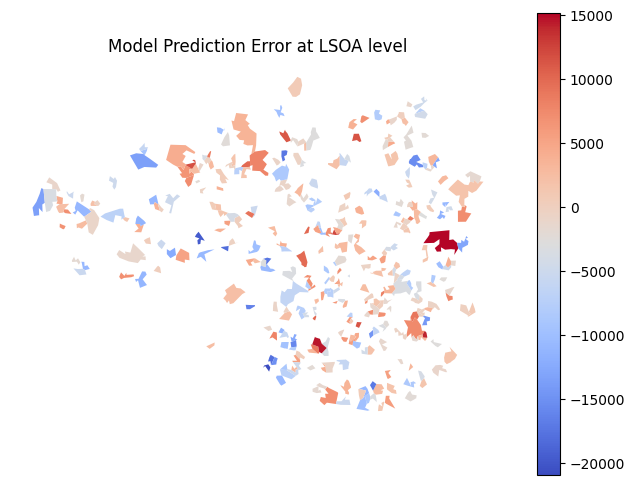

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot polygons outlines for context
# gm_lsoa.boundary.plot(ax=ax, color='black', linewidth=0.2)
# Plot test points with error coloration
test_points.plot(column='error', ax=ax, legend=True, cmap='coolwarm', markersize=50)
ax.set_title("Model Prediction Error at LSOA level")
ax.axis('off')
plt.show()

### Use the model to make predictions using a different deprivation dimensions?

In [62]:
imd.columns

Index(['LSOA11CD', 'lsoa_2011_name', 'lad_2019_code', 'lad_2019_name',
       'imd_rank', 'imd_decile', 'income_rank', 'income_decile',
       'employment_rank', 'employment_decile', 'education_rank',
       'education_decile', 'health_rank', 'health_decile', 'crime_rank',
       'crime_decile', 'housing_rank', 'housing_decile', 'environment_rank',
       'environment_decile'],
      dtype='object')

In [63]:
X = np.stack(avg_embeddings_with_imd_gdf["embedding"].values)     # shape (n_points, embed_dim)
y = avg_embeddings_with_imd_gdf['income_decile'].values

print("Feature matrix shape:", X.shape, "Target vector shape:", y.shape)

# Split data into training and test sets
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X , y, np.arange(X.shape[0]), test_size=0.2, random_state=42)
print(f"Training points: {X_train.shape[0]}, Test points: {X_test.shape[0]}")

Feature matrix shape: (1669, 768) Target vector shape: (1669,)
Training points: 1335, Test points: 334


In [83]:
final_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 MLPRegressor(alpha=0.001, early_stopping=True,
                              hidden_layer_sizes=(100, 50), max_iter=2000,
                              n_iter_no_change=20, random_state=42))])

In [84]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 MLPRegressor(alpha=0.001, early_stopping=True,
                              hidden_layer_sizes=(100, 50), max_iter=2000,
                              n_iter_no_change=20, random_state=42))])

In [85]:
# Rebuild the model pipeline with the optimal hyperparameters
if best_model_name == "LinearReg":
    final_model = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', LinearRegression()) ])
elif best_model_name == "RandomForest":
    final_model = Pipeline([
        ('scaler', StandardScaler()),  # optional; RF ignores it
        ('reg', RandomForestRegressor(random_state=42, **best_params))])
elif best_model_name == "NeuralNet":
    # Remove 'reg__' prefix from best_params
    clean_params = {k.replace('reg__',''): v for k,v in best_params.items()}

    # Build final pipeline
    final_model = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', MLPRegressor(max_iter=2000, early_stopping=True, n_iter_no_change=20,
                             random_state=42, **clean_params))])

else:
    raise ValueError(f"Unknown model: {best_model_name}")

# Train on the full training set
final_model.fit(X_train, y_train)

# Predict on the test set (or any other dataset)
y_pred = final_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import r2_score, mean_squared_error
print(f"Test R^2: {r2_score(y_test, y_pred):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

# Optionally: save the trained model for later use
import joblib
model_file = os.path.join(data_dir, f"5-{best_model_name}_trained_model.joblib")
joblib.dump(final_model, model_file)
print(f"Trained model saved to {model_file}")


Test R^2: 0.626
Test RMSE: 1.844
Trained model saved to ../data/airbnb-manchester/5-NeuralNet_trained_model.joblib
